### **Animal Image Classifier using CNN**

**1. Data Preparation & Exploration**
- Download and extract the dataset (from Kaggle or your local folder).
- Organize images into train/validation/test folders by class.
- Visualize sample images from each class.
- Perform data augmentation to increase robustness.. Data Preparation & Exploration

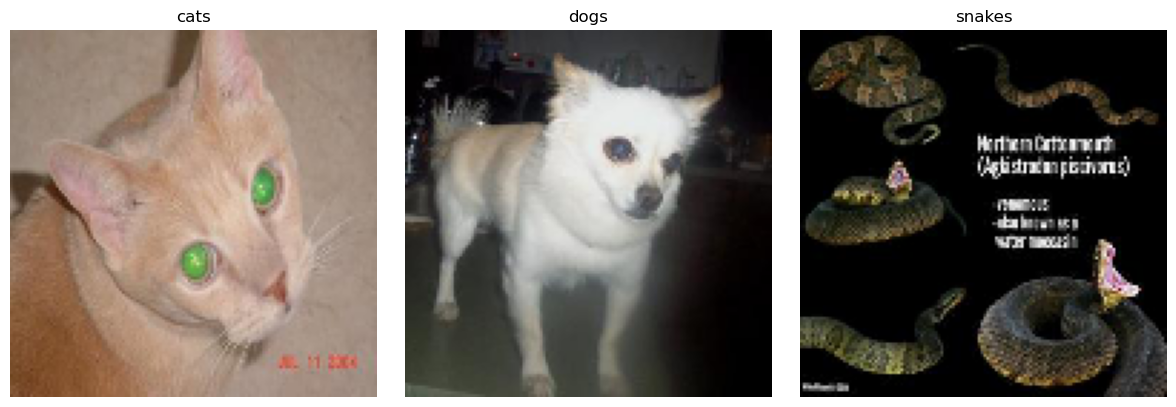

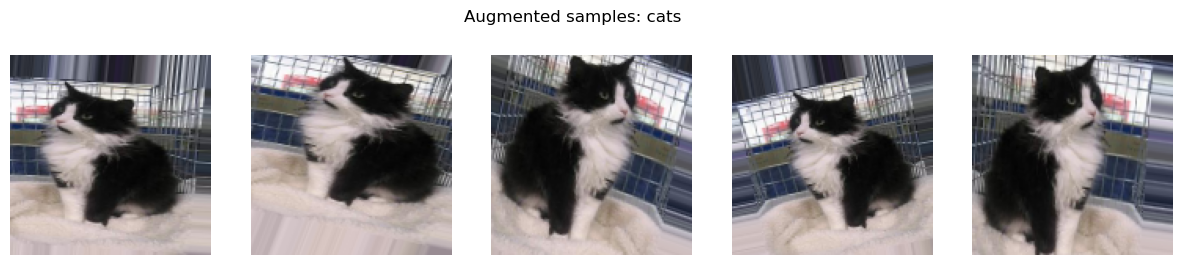

In [10]:
import os
import shutil
import random
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import matplotlib.pyplot as plt

# Set paths
base_dir = 'dataset/Animals'
classes = ['cats', 'dogs', 'snakes']
output_base = 'dataset/organized'

# Create train/val/test split
split_ratios = {'train': 0.8, 'val': 0.1, 'test': 0.1}

# Organize images into train/val/test folders
if not os.path.exists(output_base):
    for cls in classes:
        img_paths = glob(os.path.join(base_dir, cls, '*'))
        random.shuffle(img_paths)
        n_total = len(img_paths)
        n_train = int(n_total * split_ratios['train'])
        n_val = int(n_total * split_ratios['val'])
        splits = {
            'train': img_paths[:n_train],
            'val': img_paths[n_train:n_train + n_val],
            'test': img_paths[n_train + n_val:]
        }
        for split, files in splits.items():
            split_dir = os.path.join(output_base, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for f in files:
                shutil.copy(f, split_dir)

# Visualize sample images from each class
fig, axes = plt.subplots(1, len(classes), figsize=(12, 4))
for idx, cls in enumerate(classes):
    sample_dir = os.path.join(output_base, 'train', cls)
    sample_img = random.choice(os.listdir(sample_dir))
    img_path = os.path.join(sample_dir, sample_img)
    img = load_img(img_path, target_size=(128, 128))
    axes[idx].imshow(img)
    axes[idx].set_title(cls)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualize augmented images for one sample
sample_dir = os.path.join(output_base, 'train', classes[0])
sample_img = random.choice(os.listdir(sample_dir))
img_path = os.path.join(sample_dir, sample_img)
img = load_img(img_path, target_size=(128, 128))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
i = 0
for batch in datagen.flow(x, batch_size=1):
    ax[i].imshow(batch[0].astype('uint8'))
    ax[i].axis('off')
    i += 1
    if i == 5:
        break
plt.suptitle(f'Augmented samples: {classes[0]}')
plt.show()

**2. Data Loading with Keras**
- Use `ImageDataGenerator` for loading and augmenting images.
- Split data into training, validation, and test sets.

In [11]:
# Prepare ImageDataGenerators for train, validation, and test sets
train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
test_dir = os.path.join(output_base, 'test')

img_height, img_width = 128, 128  # Standard for transfer learning
batch_size = 32  # batch_size means number of images processed together 

# Training data generator with augmentation
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation and test generators without augmentation
test_val_datagen = ImageDataGenerator()
val_gen = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_gen = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


**3. Load Pre-trained ResNet Model**
- Use ResNet50 (or ResNet101 for more complexity) with imagenet weights.
- Exclude the top layer (include_top=False) to add custom layers.

In [12]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 with imagenet weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model layers

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

**4. Add Custom Layers**
- Add Global Average Pooling, Dropout, Dense layers, and a final softmax output layer.

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Add custom layers on top of the base_model
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**5. Freeze Pre-trained Layers**
- Freeze all layers in the ResNet base to train only the custom head.

In [14]:
for layer in base_model.layers:
    layer.trainable = False

# Optionally, check if all layers are frozen
print("All base_model layers frozen:", all(not layer.trainable for layer in base_model.layers))

All base_model layers frozen: True


**6. Compile and Train the Model (Initial Training)**
- Use Adam optimizer, categorical crossentropy, and accuracy metrics.
- Add callbacks: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau.

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train the model
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=callbacks
)

c:\Users\This PC\.conda\envs\infotech_course\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5577 - loss: 1.2418
Epoch 1: val_loss improved from inf to 0.32776, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 392ms/step - accuracy: 0.5595 - loss: 1.2365 - val_accuracy: 0.8933 - val_loss: 0.3278 - learning_rate: 1.0000e-04
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8269 - loss: 0.4896
Epoch 2: val_loss improved from 0.32776 to 0.23459, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.8270 - loss: 0.4890 - val_accuracy: 0.9289 - val_loss: 0.2346 - learning_rate: 1.0000e-04
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8841 - loss: 0.3163
Epoch 3: val_loss improved from 0.23459 to 0.21907, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.8839 - loss: 0.3167 - val_accuracy: 0.9267 - val_loss: 0.2191 - learning_rate: 1.0000e-04
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8729 - loss: 0.3434
Epoch 4: val_loss improved from 0.21907 to 0.21174, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 356ms/step - accuracy: 0.8730 - loss: 0.3432 - val_accuracy: 0.9311 - val_loss: 0.2117 - learning_rate: 1.0000e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8906 - loss: 0.2978
Epoch 5: val_loss improved from 0.21174 to 0.20588, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - accuracy: 0.8905 - loss: 0.2981 - val_accuracy: 0.9311 - val_loss: 0.2059 - learning_rate: 1.0000e-04
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9103 - loss: 0.2478
Epoch 6: val_loss improved from 0.20588 to 0.19631, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 358ms/step - accuracy: 0.9102 - loss: 0.2481 - val_accuracy: 0.9356 - val_loss: 0.1963 - learning_rate: 1.0000e-04
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9057 - loss: 0.2496
Epoch 7: val_loss did not improve from 0.19631
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 355ms/step - accuracy: 0.9057 - loss: 0.2497 - val_accuracy: 0.9356 - val_loss: 0.2035 - learning_rate: 1.0000e-04
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9070 - loss: 0.2133
Epoch 8: val_loss did not improve from 0.19631

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 363ms/step - accuracy: 0.9071 - loss: 0.2133 - val_accuracy: 0.9356 - val_loss: 0.1990 - learning_rate: 1.0000e-04
Epoch 9/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9253 - loss: 0.1990
Epoch 9: val_loss improved from 0.19631 to 0.19373, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 363ms/step - accuracy: 0.9252 - loss: 0.1992 - val_accuracy: 0.9356 - val_loss: 0.1937 - learning_rate: 5.0000e-05
Epoch 10/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 305s/step - accuracy: 0.9168 - loss: 0.2070  
Epoch 10: val_loss improved from 0.19373 to 0.19241, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 19826s 305s/step - accuracy: 0.9168 - loss: 0.2071 - val_accuracy: 0.9400 - val_loss: 0.1924 - learning_rate: 5.0000e-05
Epoch 11/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9218 - loss: 0.2028
Epoch 11: val_loss improved from 0.19241 to 0.18791, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 380ms/step - accuracy: 0.9217 - loss: 0.2030 - val_accuracy: 0.9400 - val_loss: 0.1879 - learning_rate: 5.0000e-05
Epoch 12/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9033 - loss: 0.2367
Epoch 12: val_loss did not improve from 0.18791
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.9034 - loss: 0.2364 - val_accuracy: 0.9422 - val_loss: 0.1887 - learning_rate: 5.0000e-05
Epoch 13/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9207 - loss: 0.2116
Epoch 13: val_loss did not improve from 0.18791

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9208 - loss: 0.2115 - val_accuracy: 0.9422 - val_loss: 0.1900 - learning_rate: 5.0000e-05
Epoch 14/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9239 - loss: 0.2007
Epoch 14: val_loss did not improve from 0.18791
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 400ms/step - accuracy: 0.9239 - loss: 0.2007 - v

66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.9098 - loss: 0.2183 - val_accuracy: 0.9444 - val_loss: 0.1863 - learning_rate: 1.2500e-05
Epoch 17/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9153 - loss: 0.2165
Epoch 17: val_loss improved from 0.18632 to 0.18520, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 367ms/step - accuracy: 0.9154 - loss: 0.2163 - val_accuracy: 0.9444 - val_loss: 0.1852 - learning_rate: 1.2500e-05
Epoch 18/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9325 - loss: 0.1946
Epoch 18: val_loss did not improve from 0.18520
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 361ms/step - accuracy: 0.9326 - loss: 0.1944 - val_accuracy: 0.9400 - val_loss: 0.1870 - learning_rate: 1.2500e-05
Epoch 19/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9262 - loss: 0.1922
Epoch 19: val_loss did not improve from 0.18520

Epoch 19: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 361ms/step - accuracy: 0.9262 - loss: 0.1923 - val_accuracy: 0.9422 - val_loss: 0.1862 - learning_rate: 1.2500e-05
Epoch 20/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9190 - loss: 0.2148
Epoch 20: val_loss did not improve from 0.18520
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.9191 - loss: 0.2145 - va

**7. Fine-tune the Model**
- Unfreeze some top layers of ResNet for fine-tuning.
- Retrain with a lower learning rate.

In [16]:
# Unfreeze the top layers of the base_model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Retrain the model
fine_tune_history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9268 - loss: 0.1968
Epoch 1: val_loss improved from 0.18520 to 0.17922, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 444ms/step - accuracy: 0.9268 - loss: 0.1968 - val_accuracy: 0.9400 - val_loss: 0.1792 - learning_rate: 1.0000e-06
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9181 - loss: 0.2001
Epoch 2: val_loss improved from 0.17922 to 0.17822, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 432ms/step - accuracy: 0.9181 - loss: 0.2001 - val_accuracy: 0.9378 - val_loss: 0.1782 - learning_rate: 1.0000e-06
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9096 - loss: 0.2156
Epoch 3: val_loss improved from 0.17822 to 0.17786, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 409ms/step - accuracy: 0.9096 - loss: 0.2154 - val_accuracy: 0.9378 - val_loss: 0.1779 - learning_rate: 1.0000e-06
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9170 - loss: 0.2163
Epoch 4: val_loss improved from 0.17786 to 0.17734, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - accuracy: 0.9169 - loss: 0.2163 - val_accuracy: 0.9400 - val_loss: 0.1773 - learning_rate: 1.0000e-06
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9253 - loss: 0.1899
Epoch 5: val_loss improved from 0.17734 to 0.17638, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.9252 - loss: 0.1901 - val_accuracy: 0.9378 - val_loss: 0.1764 - learning_rate: 1.0000e-06
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9055 - loss: 0.2120
Epoch 6: val_loss did not improve from 0.17638
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 401ms/step - accuracy: 0.9057 - loss: 0.2119 - val_accuracy: 0.9378 - val_loss: 0.1765 - learning_rate: 1.0000e-06
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9249 - loss: 0.1983
Epoch 7: val_loss improved from 0.17638 to 0.17577, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.9250 - loss: 0.1981 - val_accuracy: 0.9378 - val_loss: 0.1758 - learning_rate: 1.0000e-06
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9181 - loss: 0.2082
Epoch 8: val_loss improved from 0.17577 to 0.17527, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9181 - loss: 0.2081 - val_accuracy: 0.9356 - val_loss: 0.1753 - learning_rate: 1.0000e-06
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9169 - loss: 0.1955
Epoch 9: val_loss improved from 0.17527 to 0.17522, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9168 - loss: 0.1957 - val_accuracy: 0.9356 - val_loss: 0.1752 - learning_rate: 1.0000e-06
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9253 - loss: 0.1949
Epoch 10: val_loss improved from 0.17522 to 0.17508, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.9253 - loss: 0.1948 - val_accuracy: 0.9356 - val_loss: 0.1751 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 10.


**8. Evaluate and Visualize**
- Plot training/validation accuracy and loss.
- Show confusion matrix and classification report.
- Visualize predictions on test images.

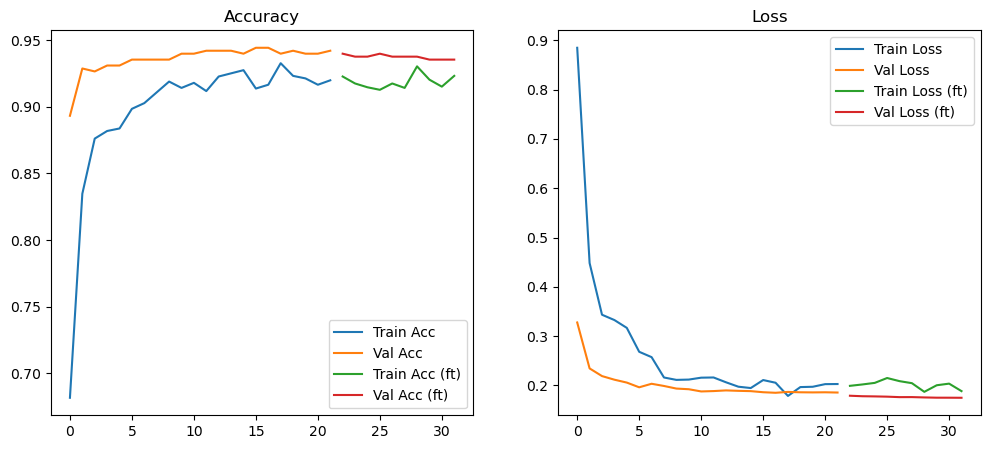

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step


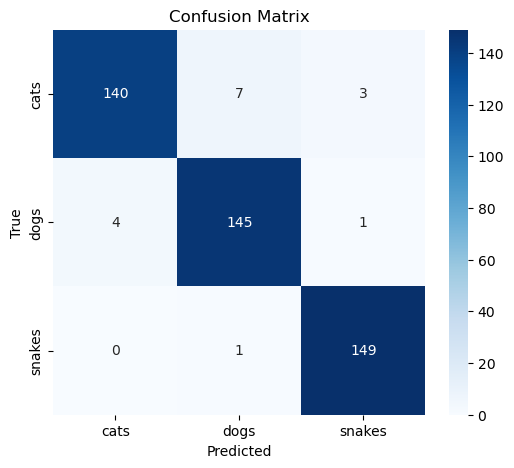

Classification Report:
              precision    recall  f1-score   support

        cats       0.97      0.93      0.95       150
        dogs       0.95      0.97      0.96       150
      snakes       0.97      0.99      0.98       150

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


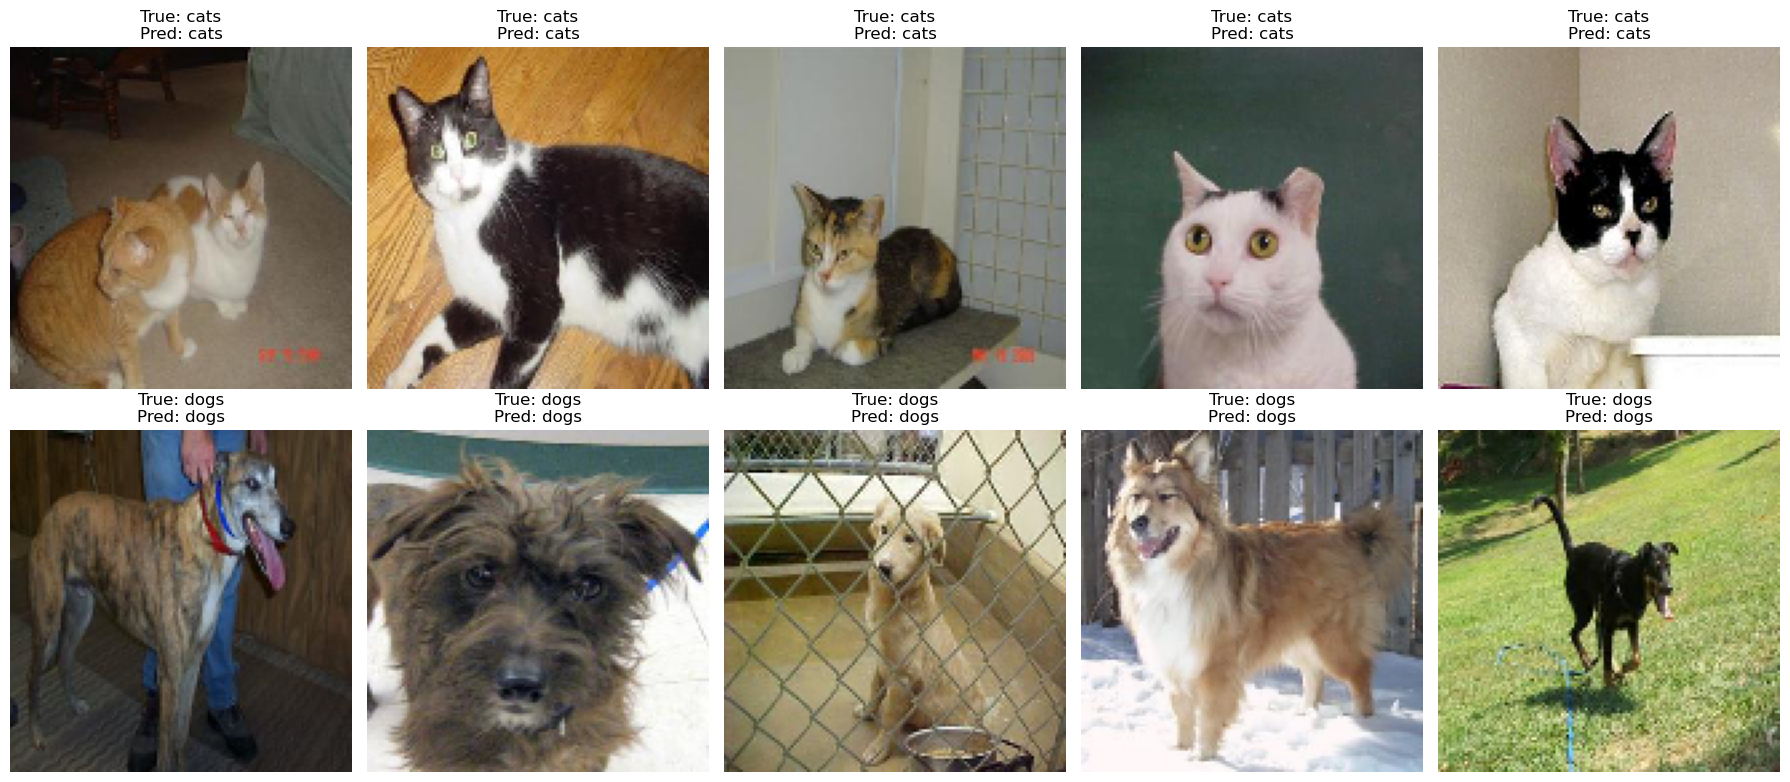

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Plot training/validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(history.history['accuracy'], label='Train Acc')
axs[0].plot(history.history['val_accuracy'], label='Val Acc')
if 'accuracy' in fine_tune_history.history:
    axs[0].plot(np.arange(len(history.history['accuracy']), len(history.history['accuracy']) + len(fine_tune_history.history['accuracy'])), fine_tune_history.history['accuracy'], label='Train Acc (ft)')
    axs[0].plot(np.arange(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(fine_tune_history.history['val_accuracy'])), fine_tune_history.history['val_accuracy'], label='Val Acc (ft)')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
if 'loss' in fine_tune_history.history:
    axs[1].plot(np.arange(len(history.history['loss']), len(history.history['loss']) + len(fine_tune_history.history['loss'])), fine_tune_history.history['loss'], label='Train Loss (ft)')
    axs[1].plot(np.arange(len(history.history['val_loss']), len(history.history['val_loss']) + len(fine_tune_history.history['val_loss'])), fine_tune_history.history['val_loss'], label='Val Loss (ft)')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()

# Predict on test set
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Visualize predictions on test images
test_gen.reset()
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
for i, ax in enumerate(axes.flat):
    img, label = next(test_gen)
    pred_idx = np.argmax(model.predict(img), axis=1)[0]
    true_idx = np.argmax(label, axis=1)[0]
    ax.imshow(img[0].astype('uint8'))
    ax.set_title(f"True: {classes[true_idx]}\nPred: {classes[pred_idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

**9. Save and Export the Model**

In [18]:
# Save the trained model in HDF5 format
model.save('final_model.h5')

print("Model saved as 'final_model.h5'")

Model saved as 'final_model.h5'
